# PRMT-2131 - TPP-EMIS transfers with error code 30s all contain attachments over a certain size

## Hypothesis

We believe that TPP-->EMIS transfers that failed due to error code 30 all contain at least one attachment over a certain size 

We will know this to be true when we see that these transfers all contain an attachment over a certain size, where successful TPP-->EMIS transfers do not contain attachments of this size


## Scope 

Take a months worth of TPP-->EMIS transfers

User attachments dataset to identify, for transfers failed with error code 30, 

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import transfer files to extract whether message creator is sender or requester
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-sample-5/"
transfer_files = [
    "2021-1-transfers.parquet",
    "2021-2-transfers.parquet",
    "2021-3-transfers.parquet"
]

transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

# In the data from the PRMT-1742-duplicates-analysis branch, these columns have been added , but contain only empty values.
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)
transfers = transfers_raw.copy()

# Correctly interpret certain sender errors as failed.
# This is explained in PRMT-1974. Eventually this will be fixed upstream in the pipeline.
# Step Two: reclassifying the relevant transfers with pending sender error codes to FAILED DUE TO SENDER ERROR CODE status for comparison
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED DUE TO SENDER ERROR CODE'

# Add integrated Late status
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

# If the record integrated after 28 days, change the status back to pending.
# This is to handle each month consistently and to always reflect a transfers status 28 days after it was made.
# TBD how this is handled upstream in the pipeline
twenty_eight_days_in_seconds=28*24*60*60
transfers_after_month_bool=transfers['sla_duration']>twenty_eight_days_in_seconds
transfers_pending_at_month_bool=transfers_after_month_bool & transfers_integrated_late_bool
transfers.loc[transfers_pending_at_month_bool,'status']='PENDING'
transfers_with_early_error_bool=(~transfers.loc[:,'sender_error_code'].isna()) |(~transfers.loc[:,'intermediate_error_codes'].apply(len)>0)
transfers.loc[transfers_with_early_error_bool & transfers_pending_at_month_bool,'status']='PENDING_WITH_ERROR'

# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

# Generate ASID lookup that contains all the most recent entry for all ASIDs encountered
asid_file_location = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/"
asid_files = [
    "asidLookup-Nov-2020.csv.gz",
    "asidLookup-Dec-2020.csv.gz",
    "asidLookup-Jan-2021.csv.gz",
    "asidLookup-Feb-2021.csv.gz",
    "asidLookup-Mar-2021.csv.gz",
    "asidLookup-Apr-2021.csv.gz"
]
asid_lookup_files = [asid_file_location + f for f in asid_files]
asid_lookup = pd.concat((
    pd.read_csv(f)
    for f in asid_lookup_files
))
asid_lookup = asid_lookup.drop_duplicates().groupby("ASID").last().reset_index()
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

# Making the status to be more human readable here
transfers["status"] = transfers["status"].str.replace("_", " ").str.title()

In [3]:
# selecting TPP -> EMIS
is_tpp_to_emis = (transfers["requesting_supplier"]=="EMIS") & (transfers["sending_supplier"]=="TPP")
tpp_to_emis_transfers = transfers.loc[is_tpp_to_emis]

In [4]:
# import attachment data for tpp -> emis
tpp_to_emis_attachments = pd.read_csv("s3://prm-gp2gp-data-sandbox-dev/PRMT-2131-tpp-to-emis-attachments/tpp-to-emis-jan-march-2021-attachment-data.csv")


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Athena query to get the above data:

```sql
select * from gp2gp_attachment_metadata 
where from_iso8601_timestamp(time) >= from_iso8601_timestamp('2021-01-01T00:00:00')
and from_iso8601_timestamp(time) < from_iso8601_timestamp('2021-04-01T00:00:00')
and from_system='SystmOne'
and to_system='EMIS Web'
limit 10
```

In [5]:
# convert length into int (was being read as string)
tpp_to_emis_attachments['length'] = pd.to_numeric(tpp_to_emis_attachments['length'], errors='coerce')

In [6]:
tpp_to_emis_attachments.head()

,time,attachment_id,conversation_id,from_system,to_system,attachment_type,compressed,content_type,large_attachment,length,original_base64,internal_id
0,2021-01-29T11:25:44.532+0000,attachment72.0@test.com,A3C60EE5-402C-408F-81BB-186940E47BF1,SystmOne,EMIS Web,cid,No,image/tiff,No,38876.0,No,20210129112543329107_CCCFC7_1522284092
1,2021-01-29T11:25:44.530+0000,attachment71.0@test.com,A3C60EE5-402C-408F-81BB-186940E47BF1,SystmOne,EMIS Web,cid,No,image/tiff,No,38326.0,No,20210129112543329107_CCCFC7_1522284092
2,2021-01-29T11:25:44.529+0000,attachment70.0@test.com,A3C60EE5-402C-408F-81BB-186940E47BF1,SystmOne,EMIS Web,cid,No,image/tiff,No,37980.0,No,20210129112543329107_CCCFC7_1522284092
3,2021-01-29T11:25:44.528+0000,attachment69.0@test.com,A3C60EE5-402C-408F-81BB-186940E47BF1,SystmOne,EMIS Web,cid,No,image/tiff,No,37386.0,No,20210129112543329107_CCCFC7_1522284092
4,2021-01-29T11:25:44.526+0000,attachment68.0@test.com,A3C60EE5-402C-408F-81BB-186940E47BF1,SystmOne,EMIS Web,cid,No,image/tiff,No,37188.0,No,20210129112543329107_CCCFC7_1522284092


In [7]:
# Add column with max attachment size and total size of attachments per conversation

attachments_by_conversation = tpp_to_emis_attachments.groupby(by="conversation_id").agg({'length': ['max', 'sum']})['length']
attachments_by_conversation = attachments_by_conversation.rename({'max': 'Largest Attachment Size', 'sum': 'Total Size of Attachments'}, axis=1)


In [8]:
# combine datasets and convert length to megabytes

tpp_to_emis_transfers_and_attachments = tpp_to_emis_transfers.merge(attachments_by_conversation, left_on='conversation_id', right_index=True, how='left') 
tpp_to_emis_transfers_and_attachments[['Largest Attachment Size', 'Total Size of Attachments']] = (tpp_to_emis_transfers_and_attachments[['Largest Attachment Size', 'Total Size of Attachments']].fillna(0))/(1024**2)
tpp_to_emis_transfers_and_attachments.head()

,conversation_id,sla_duration,requesting_practice_asid,sending_practice_asid,sender_error_code,final_error_codes,intermediate_error_codes,status,date_requested,date_completed,requesting_supplier_asid,requesting_supplier,requesting_ods_code,requesting_practice_name,sending_supplier_asid,sending_supplier,sending_ods_code,sending_practice_name,Largest Attachment Size,Total Size of Attachments
20,263704B7-6A98-4434-B25E-77918B475721,101306.0,046319412048,200000015344,NaN,[nan],[],Integrated,2021-01-27 12:36:12.090,2021-01-28 16:44:44.498,046319412048,EMIS,L81038,AIR BALLOON SURGERY,200000015344,TPP,J83038,KINGSWOOD SURGERY,0.000000,0.000000
21,03E9DD25-6E8C-4141-9833-6FC745A1B853,1816981.0,926102461049,505074584044,NaN,[nan],[],Integrated Late,2021-01-09 15:45:26.270,2021-01-30 16:28:40.633,926102461049,EMIS,E84066,HAZELDENE MEDICAL CENTRE,505074584044,TPP,A81026,LINTHORPE SURGERY,8.887659,100.578884
25,88C5E049-F79B-473A-9C78-BE6B094D392F,328971.0,926102461049,689495785016,NaN,[nan],[],Integrated,2021-01-30 15:44:18.969,2021-02-03 11:07:15.895,926102461049,EMIS,E84066,HAZELDENE MEDICAL CENTRE,689495785016,TPP,K83041,ST LUKES PRIMARY CARE CENTRE,0.942348,8.693218
30,A6C94441-B186-483F-BE25-0A08DF24E24C,1293767.0,926102461049,113222006018,NaN,[nan],[],Integrated Late,2021-01-30 14:15:27.823,2021-02-14 13:38:19.771,926102461049,EMIS,E84066,HAZELDENE MEDICAL CENTRE,113222006018,TPP,E85105,ALLENBY CLINIC,2.618670,11.677427
36,CFA6BFBC-01D4-4154-83AA-499DAD811520,166226.0,363302333010,200000000882,NaN,[nan],[],Integrated,2021-01-30 11:31:29.291,2021-02-01 09:42:10.496,363302333010,EMIS,C83054,BOURNE GALLETLY PRACTICE TEAM,200000000882,TPP,C82021,THE CENTRAL SURGERY,4.515568,65.402954


In [9]:
# checking which columns actually contain error code 30
tpp_to_emis_transfers_and_attachments['sender_error_code'].value_counts()

30.0    3898
20.0     227
6.0      102
24.0      77
7.0       34
23.0      25
14.0       6
Name: sender_error_code, dtype: int64

In [10]:
tpp_to_emis_transfers_and_attachments['final_error_codes'].apply(lambda x: 30 in x).value_counts()

False    129437
Name: final_error_codes, dtype: int64

In [11]:
tpp_to_emis_transfers_and_attachments['intermediate_error_codes'].apply(lambda x: 30 in x).value_counts()

False    129437
Name: intermediate_error_codes, dtype: int64

In [12]:
# anything containing error 30
# Add contains error code 30 column
error_code_30 = (tpp_to_emis_transfers_and_attachments['sender_error_code']== 30).fillna(False)
tpp_to_emis_transfers_and_attachments.loc[error_code_30, 'Histogram categories'] = 'Contains error code 30' 

successfully_integrated = (tpp_to_emis_transfers_and_attachments['status'].isin(['Integrated', 'Integrated Late'])).fillna(False)
tpp_to_emis_transfers_and_attachments.loc[successfully_integrated, 'Histogram categories'] = 'Successfully Integrated' 

# anything successfully integrated (including integrated late and does not have err 30)

In [13]:
tpp_to_emis_transfers_and_attachments.groupby(by='Histogram categories').agg({'Largest Attachment Size': 'describe'})

Largest Attachment Size                           \
                                          count      mean       std  min   
Histogram categories                                                       
Contains error code 30                   3898.0  0.000000  0.000000  0.0   
Successfully Integrated                116449.0  4.492056  5.479586  0.0   

                                                                
                              25%     50%       75%        max  
Histogram categories                                            
Contains error code 30   0.000000  0.0000  0.000000   0.000000  
Successfully Integrated  0.968128  3.3867  5.142481  63.979555

In [14]:
tpp_to_emis_transfers_and_attachments.groupby(by='Histogram categories').agg({'Total Size of Attachments': 'describe'})

Total Size of Attachments                             \
                                            count       mean        std  min   
Histogram categories                                                           
Contains error code 30                     3898.0   0.000000   0.000000  0.0   
Successfully Integrated                  116449.0  35.572564  50.610427  0.0   

                                                                     
                              25%        50%        75%         max  
Histogram categories                                                 
Contains error code 30   0.000000   0.000000   0.000000    0.000000  
Successfully Integrated  3.002842  17.020102  46.546148  851.085915

In [15]:
has_error_30_cat = tpp_to_emis_transfers_and_attachments['Histogram categories']== 'Contains error code 30' 
tpp_to_emis_transfers_and_attachments[has_error_30_cat].sample(5)

,conversation_id,sla_duration,requesting_practice_asid,sending_practice_asid,sender_error_code,final_error_codes,intermediate_error_codes,status,date_requested,date_completed,...,requesting_supplier,requesting_ods_code,requesting_practice_name,sending_supplier_asid,sending_supplier,sending_ods_code,sending_practice_name,Largest Attachment Size,Total Size of Attachments,Histogram categories
732371,6FD506E1-E9B8-461B-80EC-BBB04DD4E9A1,NaN,200000014812,200000009145,30.0,[],[],Failed Due To Sender Error Code,2021-03-04 11:43:57.313,NaT,...,EMIS,L82016,OAK TREE SURGERY,200000009145,TPP,L83076,WYCLIFFE SURGERY,0.0,0.0,Contains error code 30
528475,7BD8EF29-22FD-4126-A8EE-4844AE6B0F2E,NaN,200000022121,248323424015,30.0,[],[],Failed Due To Sender Error Code,2021-03-25 14:04:26.484,NaT,...,EMIS,L83039,SOUTHWAY SURGERY,248323424015,TPP,L83006,MAYFLOWER MEDICAL GROUP,0.0,0.0,Contains error code 30
557459,6600B35B-3805-42B8-8007-3FCF582564A6,NaN,378333657047,081281155044,30.0,[],[],Failed Due To Sender Error Code,2021-03-23 17:30:17.522,NaT,...,EMIS,F84074,THE GRAHAM PRACTICE,081281155044,TPP,D83030,KIRKLEY MILL HEALTH CENTRE,0.0,0.0,Contains error code 30
211469,C731515C-1D61-4592-B5AF-654080E973E4,NaN,579724990018,200000001077,30.0,[],[],Failed Due To Sender Error Code,2021-01-04 10:11:31.980,NaT,...,EMIS,D82001,HOLT MEDICAL PRACTICE,200000001077,TPP,D83011,BRIDGE ROAD SURGERY,0.0,0.0,Contains error code 30
43599,4A14E47E-66AF-4EF0-A768-F49EEDD4CC02,NaN,260588267047,784578689043,30.0,[],[],Failed Due To Sender Error Code,2021-01-27 14:59:24.160,NaT,...,EMIS,H82052,POUND HILL MEDICAL GROUP,784578689043,TPP,H82615,OUSE VALLEY PRACTICE,0.0,0.0,Contains error code 30


array([[<AxesSubplot:title={'center':'Largest Attachment Size'}>]],
      dtype=object)

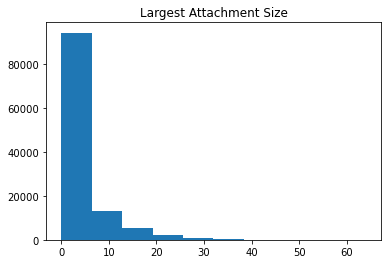

In [16]:
# plot data
successfully_integrated_bool = tpp_to_emis_transfers_and_attachments['Histogram categories']=='Successfully Integrated'
tpp_to_emis_transfers_and_attachments[successfully_integrated_bool].hist(column='Largest Attachment Size', grid=False)

array([[<AxesSubplot:title={'center':'Total Size of Attachments'}>]],
      dtype=object)

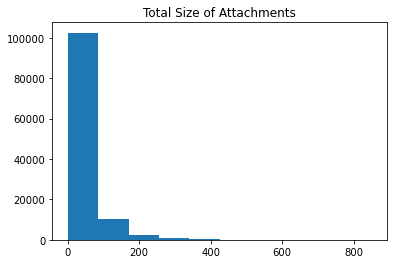

In [17]:
# plot data
successfully_integrated_bool = tpp_to_emis_transfers_and_attachments['Histogram categories']=='Successfully Integrated'
tpp_to_emis_transfers_and_attachments[successfully_integrated_bool].hist(column='Total Size of Attachments', grid=False)

In [18]:
#Extract some sample conversation IDs to send to TPP
april_transfers = pd.read_parquet("s3://prm-gp2gp-data-sandbox-dev/transfers-sample-5/2021-4-transfers.parquet")

In [19]:
tpp_to_emis_error30_failed_bool = (april_transfers['sender_error_code']==30) & (april_transfers['status'] == 'PENDING_WITH_ERROR') & (april_transfers['sending_supplier'] == 'SystmOne') & (april_transfers['requesting_supplier'] == 'EMIS') 
tpp_to_emis_error30_failed = april_transfers.loc[tpp_to_emis_error30_failed_bool, 'conversation_id']
tpp_to_emis_error30_failed.sample(20).values

array(['D7397590-17E3-4E28-98DE-B5723FB3AA2C',
       '7B052DD3-A3A4-4C09-B109-11D64D935A66',
       'F4BCEB76-9DA4-4788-8D31-0F971085D673',
       '3C08BE6E-5148-4209-9D33-3603DFF99C7D',
       '2BEC9F4E-9E77-41B6-B0F3-A3CB7A5D6736',
       '6314ED1C-C77A-4543-8B2F-10846F23E052',
       '807087EE-60D1-4EEB-AB83-20F62E28AC43',
       'AE159949-1AB8-40FA-ABF2-BB7C19201965',
       'DD6CD3E5-395E-42F1-8F61-6329D6B45FD2',
       '286772A4-6815-4F41-AB0A-0BA72428CF6F',
       '6A0CE86C-BB91-4195-854D-370024A70B0B',
       'EAA0DE2F-7EB2-41DC-968A-D644B9571059',
       '4C2A5373-9D5E-4647-A813-6A12B80A764C',
       '4EBB5709-B9C6-46F4-A52B-51AD46CB9C5E',
       '9209E2B8-D097-41FD-9F72-B55BD63443A7',
       '84249F81-A027-4F70-B18E-91594CFCDFEC',
       '4C595EBB-EFF2-4A23-9DD1-4E3986739E8B',
       '3C59A260-CE69-4326-ABE3-51E1FAE74705',
       '396F715A-9600-4DA2-8FA0-F81AACC4602A',
       'DAE0339D-D43C-426C-9B00-C626D54C6989'], dtype=object)

In [20]:
april_transfers['status'].value_counts().index

Index(['INTEGRATED', 'PENDING', 'PENDING_WITH_ERROR', 'FAILED'], dtype='object')

## Check EMIS to EMIS transfer metadata for comparison. 
This is to see if the file size distribution for successful transfers is similar to EMIS -> EMIS


In [21]:
# import attachment data for emis -> emis
emis_to_emis_attachments = pd.read_csv("s3://prm-gp2gp-data-sandbox-dev/PRMT-2131-tpp-to-emis-attachments/emis-to-emis-jan-march-2021-attachment-data.csv")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
# convert length into int (was being read as string)
emis_to_emis_attachments['length'] = pd.to_numeric(emis_to_emis_attachments['length'], errors='coerce')
emis_to_emis_attachments.head()

,time,attachment_id,conversation_id,from_system,to_system,attachment_type,compressed,content_type,large_attachment,length,original_base64,internal_id
0,2021-02-28T21:11:19.361+0000,3265D84C-D952-49A3-B184-65D231C83C0D,1CF040AE-84BD-4555-84C0-E8B1FED08CF8,EMIS Web,EMIS Web,mid,No,image/tiff,No,1871216.0,No,20210228211119332479_80A054_1524269712
1,2021-02-28T21:11:19.360+0000,1C3D72EC-5C55-4ECB-BCCA-9F6AF1BEDB83,1CF040AE-84BD-4555-84C0-E8B1FED08CF8,EMIS Web,EMIS Web,mid,No,image/tiff,No,4718592.0,No,20210228211119332479_80A054_1524269712
2,2021-02-28T21:11:19.359+0000,E7BF8816-0612-43D5-BC54-CB31B7763DFF,1CF040AE-84BD-4555-84C0-E8B1FED08CF8,EMIS Web,EMIS Web,mid,No,image/tiff,No,4718592.0,No,20210228211119332479_80A054_1524269712
3,2021-02-28T21:11:19.358+0000,Attachment1@e-mis.com/EMISWeb/GP2GP2.2A,1CF040AE-84BD-4555-84C0-E8B1FED08CF8,EMIS Web,EMIS Web,cid,No,image/tiff,No,4718592.0,No,20210228211119332479_80A054_1524269712
4,2021-02-28T20:18:25.657+0000,Attachment1@e-mis.com/EMISWeb/GP2GP2.2A,8BD7BC1F-5E15-4059-A740-9718F475F821,EMIS Web,EMIS Web,cid,Yes,application/pdf,No,91504.0,No,20210228201825648909_3FFA55_1524269712


In [23]:
# Add column with max attachment size and total size of attachments per conversation

emis_attachments_by_conversation = emis_to_emis_attachments.groupby(by="conversation_id").agg({'length': ['max', 'sum']})['length']
emis_attachments_by_conversation = emis_attachments_by_conversation.rename({'max': 'Largest Attachment Size', 'sum': 'Total Size of Attachments'}, axis=1)


In [24]:
# selecting EMIS -> EMIS
is_emis_to_emis = (transfers["requesting_supplier"]=="EMIS") & (transfers["sending_supplier"]=="EMIS")
emis_to_emis_transfers = transfers.loc[is_emis_to_emis]

In [25]:
# combine datasets and convert length to megabytes

emis_to_emis_transfers_and_attachments = emis_to_emis_transfers.merge(emis_attachments_by_conversation, left_on='conversation_id', right_index=True, how='left') 
emis_to_emis_transfers_and_attachments[['Largest Attachment Size', 'Total Size of Attachments']] = (emis_to_emis_transfers_and_attachments[['Largest Attachment Size', 'Total Size of Attachments']].fillna(0))/(1024**2)
emis_to_emis_transfers_and_attachments.head()

,conversation_id,sla_duration,requesting_practice_asid,sending_practice_asid,sender_error_code,final_error_codes,intermediate_error_codes,status,date_requested,date_completed,requesting_supplier_asid,requesting_supplier,requesting_ods_code,requesting_practice_name,sending_supplier_asid,sending_supplier,sending_ods_code,sending_practice_name,Largest Attachment Size,Total Size of Attachments
0,46F9B8DF-F67C-4B38-829A-DEFE62207B29,523271.0,568801526019,467110515013,NaN,[nan],[],Integrated,2021-01-27 12:36:51.592,2021-02-02 14:01:44.722,568801526019,EMIS,B81109,RIVERSIDE SURGERY,467110515013,EMIS,C82043,STATION VIEW HEALTH CENTRE,1.470844,16.829922
1,8705FE2B-32CC-43BA-98A6-9C77505632BD,2479.0,923086194043,598420833017,NaN,[nan],[],Integrated,2021-01-27 12:38:42.828,2021-01-27 13:21:28.991,923086194043,EMIS,J82129,NEW FOREST MEDICAL GROUP,598420833017,EMIS,J82134,VINE MEDICAL GROUP,1.690678,18.717579
3,C7A0A547-BD7C-4E0E-9D23-E831F7568073,375.0,686703194015,742805593040,NaN,[nan],[],Integrated,2021-01-27 12:40:17.576,2021-01-27 12:47:32.462,686703194015,EMIS,L81131,FALLODON WAY MEDICAL CENTRE,742805593040,EMIS,L81023,EAST TREES HEALTH CENTRE,0.720768,11.057789
4,8F7F1F46-ADB4-44F1-AEC7-1816D83A13E8,1820237.0,200000009781,059578074011,NaN,[nan],[],Integrated Late,2021-01-27 12:39:51.220,2021-02-17 14:18:42.885,200000009781,EMIS,G82229,SUTTON VALENCE GROUP PRACTICE,059578074011,EMIS,G82224,OLD PARSONAGE SURGERY,3.317364,22.922665
5,A1A2EC3B-6633-45B2-BE4B-0C5DB1FA43E4,1284.0,075356814048,200000000812,NaN,[nan],[],Integrated,2021-01-27 12:29:35.056,2021-01-27 12:58:28.264,075356814048,EMIS,G81022,SOVEREIGN PRACTICE,200000000812,EMIS,Y00080,HARBOUR MEDICAL PRACTICE,8.042309,177.580044


In [26]:
# checking which columns actually contain error code 30
emis_to_emis_transfers_and_attachments['sender_error_code'].value_counts()

20.0    3095
10.0    1573
6.0      315
19.0     164
7.0       99
99.0      73
23.0      20
14.0      15
Name: sender_error_code, dtype: int64

In [27]:
emis_to_emis_transfers_and_attachments['final_error_codes'].apply(lambda x: 30 in x).value_counts()

False    461648
Name: final_error_codes, dtype: int64

In [28]:
emis_to_emis_transfers_and_attachments['intermediate_error_codes'].apply(lambda x: 30 in x).value_counts()

False    461648
Name: intermediate_error_codes, dtype: int64

In [29]:
# mark all that are successfully integrated

emis_successfully_integrated = (emis_to_emis_transfers_and_attachments['status'].isin(['Integrated', 'Integrated Late'])).fillna(False)
emis_to_emis_transfers_and_attachments.loc[emis_successfully_integrated, 'Histogram categories'] = 'Successfully Integrated' 


In [30]:
emis_to_emis_transfers_and_attachments.groupby(by='Histogram categories').agg({'Largest Attachment Size': 'describe'})

Largest Attachment Size                                \
                                          count      mean       std  min  25%   
Histogram categories                                                            
Successfully Integrated                444903.0  1.975157  7.309171  0.0  0.0   

                                                   
                         50%       75%        max  
Histogram categories                               
Successfully Integrated  0.0  1.353445  594.00478

array([[<AxesSubplot:title={'center':'Largest Attachment Size'}>]],
      dtype=object)

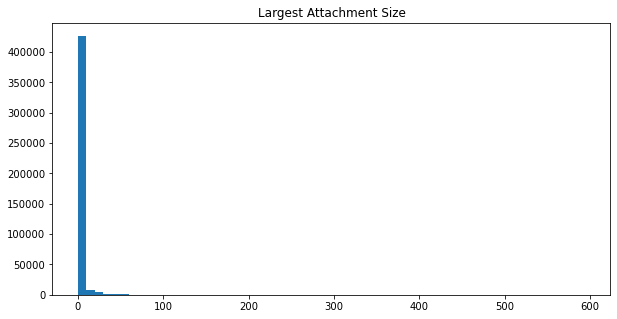

In [31]:
# plot data
emis_successfully_integrated_bool = emis_to_emis_transfers_and_attachments['Histogram categories']=='Successfully Integrated'
emis_to_emis_transfers_and_attachments[emis_successfully_integrated_bool].hist(column='Largest Attachment Size', grid=False, bins=60, figsize=(10,5))

array([[<AxesSubplot:title={'center':'Largest Attachment Size'}>]],
      dtype=object)

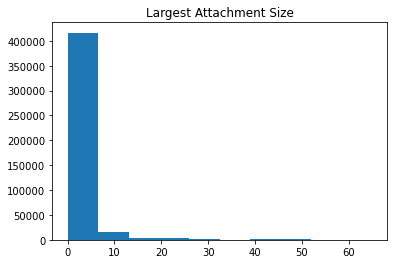

In [32]:
# check EMIS to EMIS for same range of file sizes as TPP to EMIS
emis_to_emis_transfers_and_attachments[emis_successfully_integrated_bool].hist(column='Largest Attachment Size', grid=False, range=(0,65))